In [1]:
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import csv
import random
import nltk.stem
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import expon
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
class Preprocessing:
    def __init__(self):
        self.lemmatizer_object = nltk.stem.WordNetLemmatizer()
        self.labels = []
        self.tweets = []
        Preprocessing.readFile(self,"offenseval-training-v1.tsv")
        Preprocessing.readFile(self,"labeled_data.tsv")
        Preprocessing.divide_data_set(self)

    def remove_noise(self,input_text):
        noise_list = ["a", "about", "after", "all", "also", "an", "another", "any", "and", "are", "as", "and", "at",
                      "be",
                      "because", "been", "before", "being", "between", "but", "both", "by", "came", "can", "come",
                      "could ",
                      "did", "do", "each", "even", "for", "from", "further", "furthermore", "get", "got", "has", "had",
                      "he", "have", "her", "here", "him", "himself", "his", "how", "hi", "however", "i", "if", "in",
                      "into",
                      "is", "it", "its", "indeed", "just", "like", "made", "many", "me", "might", "more", "moreover",
                      "most", "much", "must", "my never", "not", "now of", "on", "only", "other", "our", "out", "or",
                      "over", "said", "same", "see", "should", "since", "she", "some", "still", "such", "take", "than",
                      "that", "the", "their", "them", "then", "there", "these", "therefore", "they", "this", "those",
                      "through", "to", "too", "thus", "under", "up", "was", "way", "we", "well", "were", "what", "when",
                      "where", "which", "while", "who", "will", "with", "would", "your", "null"]
        words = input_text.split()  # Split words by space
        noise_free_words = [word for word in words if word.lower() not in noise_list]  # Get a list of non-noise words
        noise_free_text = " ".join(noise_free_words)  # Get a string of non-noise words
        return noise_free_text

    def remove_regex(self,input_text):
        # split tweet by space
        words = input_text.split()
        regex_free_text = ""
        # check if word is alpha(contain letters only) , then add it to regex_free_text
        for word in words:
            if word.isalpha():
                # Lemmatization, on the other hand, is an organized & step by step procedure of obtaining
                # the root form of the word, it makes use of vocabulary (dictionary importance of words)
                # and morphological analysis (word structure and grammar relations).
                # reduces the inflected words properly ensuring that the root word belongs to the language
                # pos="V"-->to give a root for each word !
                regex_free_text += self.lemmatizer_object.lemmatize(word, pos="v")  # V Msdr
                regex_free_text += " "
        return regex_free_text

    def readFile(self,filename):
        my_file = open(filename, encoding="utf-8")
        # return value of csv file is an iterator
        read = csv.reader(my_file, delimiter='\t')
        # splitting = read.split('\t')
        flag = 0
        # flag ---> used to skip the header of the file
        # column one for tweets , column 2 for our ouput(NOT or OFF)
        for row in read:
            if flag == 0:
                flag = 1
                continue;
            self.tweets.append(row[1])
            self.labels.append(row[2])

    def divide_data_set(self):
        # loop for each tweet remove regex & noise
        for tweet in range(0, len(self.tweets)):
            self.tweets[tweet] = Preprocessing.remove_regex(self,self.tweets[tweet])
            self.tweets[tweet] = Preprocessing.remove_noise(self,self.tweets[tweet])
        # we have to divide our dataset into 2 parts (training data and test data)
  #      c = list(zip(self.tweets, self.labels))
   #     random.shuffle(c)
   #     self.tweets, self.labels = zip(*c)
        lenofLabel = (int)(8*(len(self.labels)) / 10)
        self.lenofTweets = (int)(8*(len(self.tweets)) / 10)
        self.train_labels = self.labels[:lenofLabel]
        self.test_labels = self.labels[lenofLabel:]
        self.train_tweets = self.tweets[:lenofLabel]
        self.test_tweets = self.tweets[lenofLabel:]    

In [3]:
    prep = Preprocessing()
    train_labels = prep.train_labels
    test_labels = prep.test_labels
    vectorizer = TfidfVectorizer()
    features_train = vectorizer.fit_transform(prep.train_tweets)
    features_test = vectorizer.transform(prep.test_tweets)
    print("Data is pre-processed")

Data is pre-processed


0.3010511928286884


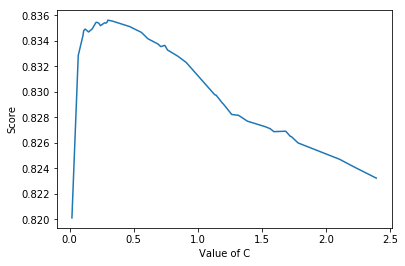

0.9472715318869165
[[1129  136]
 [ 265 6075]]


In [4]:
    #SVM_Classifier
    np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})
    ls = LinearSVC()
    ls_random = RandomizedSearchCV(estimator = ls, param_distributions = {'C': expon()}, n_iter = 50, cv = 10, verbose=0)
    ls_random.fit(features_train, train_labels)     
    scores=[]
    Cs=[]
    finalC=[]
    scores=list(ls_random.cv_results_['mean_test_score'])
    Cs=list(ls_random.cv_results_['params'])
    for c in Cs:
        if 'C' in c:
            finalC.append(c['C'])
   # print(scores)
   # print(finalC)
    ordered_Cs = []
    ordered_scores = []
    d = {finalC[i] : scores[i] for i in range(0,len(finalC))}
    optimal_c = -1
    max_acc = -1
    for k,v in collections.OrderedDict(sorted(d.items())).items():
        ordered_Cs.append(k)
        ordered_scores.append(v)
        if v >= max_acc:
            max_acc = v
            optimal_c = k
    print(optimal_c)
    plt.plot(ordered_Cs, ordered_scores)
    plt.xlabel('Value of C')
    plt.ylabel('Score')
    plt.show()
    #Rowan parameters ---->
    clf = LinearSVC(C = optimal_c,random_state=0, tol=1e-5)
    clf.fit(features_train, train_labels)
    output_labels = clf.predict(features_test)
    print(accuracy_score(output_labels, test_labels))
    print(confusion_matrix(test_labels, output_labels))
    

/home/smsm/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 1.5665901770072317}
0.8090275494772832


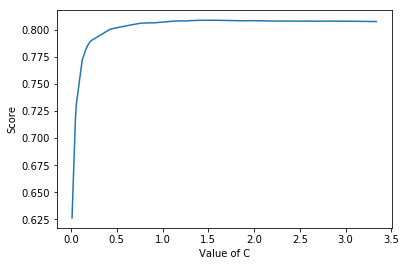

0.9487179487179487
[[1127  138]
 [ 252 6088]]


In [5]:
    #Logistic Regression Classifier
    np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})
    lr = LogisticRegression()
    lr_params = {'C': expon()}
    lr_random = RandomizedSearchCV(estimator = lr, param_distributions = lr_params, n_iter = 50, cv = 5, verbose=0)
    lr_random.fit(features_train, train_labels)
    print(lr_random.best_params_)
    print(lr_random.best_score_)      
    scores=[]
    Cs=[]
    finalC=[]
    scores=list(lr_random.cv_results_['mean_test_score'])
    Cs=list(lr_random.cv_results_['params'])
    for c in Cs:
        if 'C' in c:
            finalC.append(c['C'])
   # print(scores)
   # print(finalC)
    ordered_Cs = []
    ordered_scores = []
    d = {finalC[i] : scores[i] for i in range(0,len(finalC))}
    for k,v in collections.OrderedDict(sorted(d.items())).items():
        ordered_Cs.append(k)
        ordered_scores.append(v)
    plt.plot(ordered_Cs, ordered_scores)
    plt.xlabel('Value of C')
    plt.ylabel('Score')
    plt.show()
    #Rowan parameters ---->       
    clf = LogisticRegression(ordered_Cs[-1], solver='liblinear', multi_class='auto')
    clf.fit(features_train, train_labels)
    output_labels = clf.predict(features_test)
    print(accuracy_score(output_labels, test_labels))
    print(confusion_matrix(test_labels, output_labels))

In [9]:
    #Random-Forest Classifier
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    #cv---> 3dad el folds , n_iter kam combination ygrbha , estimator eh hwa classifier el 7y3ml tuning , n_jobs 3dad el cores                 el 7ysh3'lha verbose--->btktb m3lomat 3n running
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 4, verbose=0,              
    random_state=42, n_jobs=-1, refit=True)
    # Fit the random search models
    rf_random.fit(features_train, train_labels)
    print(rf_random.best_params_)
    #Merna's parameters ---->
    clf = RandomForestClassifier(n_estimators=800,min_samples_split = 5, min_samples_leaf = 2,max_features = 'auto',         
    max_depth = 110)
    clf.fit(features_train, train_labels)  
    output_labels = clf.predict(features_test)
    print(accuracy_score(output_labels, test_labels))
    print(confusion_matrix(test_labels, output_labels))

/home/smsm/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:686: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


NameError: name 'labels_train' is not defined

In [6]:
    #Naive-Bayes Classifier
    clf = MultinomialNB()
    clf.fit(features_train, train_labels)
    output_labels = clf.predict(features_test)
    print(accuracy_score(output_labels, test_labels))
    print(confusion_matrix(test_labels, output_labels))

0.8983563445101906
[[ 557  708]
 [  65 6275]]


1


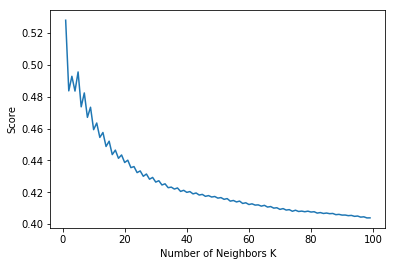

0.5101906640368179
[[1143  122]
 [3603 2737]]


In [7]:
    #KNN Classifier
    neighbors = list(range(1,100))
    cv_scores = []
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, features_train, train_labels, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
    MSE = [1 - x for x in cv_scores]
    optimal_k = neighbors[MSE.index(min(MSE))]
    print(optimal_k)
    plt.plot(neighbors, cv_scores)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Score')
    plt.show()
    clf = KNeighborsClassifier(n_neighbors = optimal_k)
    clf.fit(features_train, train_labels)
    output_labels = clf.predict(features_test)
    print(accuracy_score(output_labels,test_labels))
    print(confusion_matrix(test_labels, output_labels))

Gini: 57



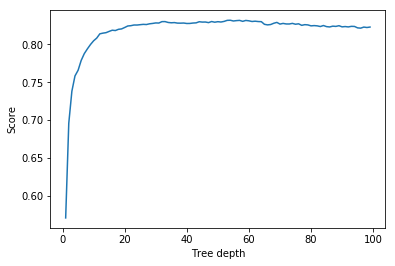

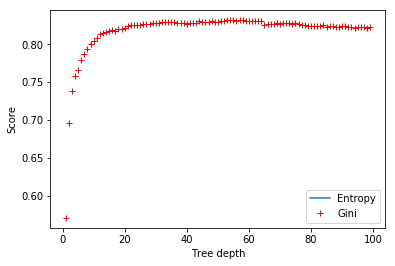

0.9380670611439842
[[1178   87]
 [ 384 5956]]


In [8]:
    #Decision-Trees Classifier
    depth = list(range(1,100))
    cv_scores_gini = []
    cv_scores_entropy = []
    ans = ""
    for m in depth:
        dt_gini = DecisionTreeClassifier(max_depth = m)
        dt_entropy = DecisionTreeClassifier(criterion = 'entropy',max_depth = m)
        scores_gini = cross_val_score(dt_gini, features_train, train_labels, cv=5, scoring='accuracy')
        scores_entropy = cross_val_score(dt_gini, features_train, train_labels, cv=5, scoring='accuracy')
        cv_scores_gini.append(scores_gini.mean())
        cv_scores_entropy.append(scores_entropy.mean())
    MSE_entropy = [1 - x for x in cv_scores_entropy]
    MSE_gini = [1 - x for x in cv_scores_gini]
    optimal_d_entropy = depth[MSE_entropy.index(min(MSE_entropy))]
    optimal_d_gini = depth[MSE_gini.index(min(MSE_gini))]
    if(optimal_d_entropy >= optimal_d_gini):
        print("Entropy: " + str(optimal_d_entropy) + "\n")
        ans = "entropy"
    else:
        print("Gini: " + str(optimal_d_gini) + "\n")
        ans = "gini"
    plot1, = plt.plot(depth, cv_scores_entropy, label ='Entropy')
    plt.xlabel('Tree depth')
    plt.ylabel('Score')
    plt.show()
    plot2, = plt.plot(depth, cv_scores_gini, 'r+', label = 'Gini')
    plt.xlabel('Tree depth')
    plt.ylabel('Score')
    plt.legend(handles=[plot1, plot2])
    plt.show()
    tree_clf = DecisionTreeClassifier(criterion = str(ans) , max_depth = int(max([optimal_d_entropy,optimal_d_gini])))
    tree_clf.fit(features_train, train_labels)
    output_labels = tree_clf.predict(features_test)
    print(accuracy_score(output_labels,test_labels))
    print(confusion_matrix(test_labels, output_labels))


In [10]:
logistic = LogisticRegression(C=1.56, solver='liblinear', multi_class='auto')
randomForest = RandomForestClassifier(n_estimators=800,min_samples_split = 5, min_samples_leaf = 2,max_features = 'auto',         
    max_depth = None)
svm = SVC(C=0.30105,kernel='linear',probability=True)
KNN = KNeighborsClassifier(n_neighbors = 44)
nb = MultinomialNB()
tree_clf = DecisionTreeClassifier(criterion = "entropy" , max_depth = 56)
voting_clf = VotingClassifier(
estimators=[('lr', logistic), ('rf', randomForest),('nb',nb),('svm',svm)],voting='soft')
voting_clf.fit(features_train, train_labels)
output_labels = voting_clf.predict(features_test)
print(accuracy_score(output_labels,test_labels))

0.9466140696909928
